In [2]:
%load_ext autoreload

%autoreload 2

import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision import transforms

from utils import _DeepLiftShap, _GradCAMPlusPlus, SimpleUpsampling, ERFUpsampling,ERFUpsamplingFast, cut_model_from_layer, cut_model_to_layer
from data import PascalVOC2007
from results.results_metrics import ResultMetrics
from models import vgg11_PascalVOC, vgg_preprocess

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
torch.manual_seed(123)
np.random.seed(123)

In [3]:
model = vgg11_PascalVOC()
model.to(device)
# Load the pretrained weights
model.load_state_dict(torch.load('VGG11_PascalVOC.pt', map_location=device))
model.eval()

preprocess = vgg_preprocess

In [4]:
test_data = PascalVOC2007("test", transform=preprocess)
train_data = PascalVOC2007("train", transform=preprocess)

Using downloaded and verified file: data\VOCtest_06-Nov-2007.tar
Extracting data\VOCtest_06-Nov-2007.tar to data
Using downloaded and verified file: data\VOCtrainval_06-Nov-2007.tar
Extracting data\VOCtrainval_06-Nov-2007.tar to data


In [5]:
import torch.utils
from torch.utils.data import Subset

BATCH_SIZE_TEST = 1
NUM_TEST = 2

NUM_TRAIN = 8
BATCH_SIZE_TRAIN = 1

dl_test = DataLoader(Subset(test_data, torch.randperm(len(test_data))[:NUM_TEST]), batch_size=BATCH_SIZE_TEST, shuffle=False)
dl_train = DataLoader(Subset(train_data, torch.randperm(len(train_data))[:NUM_TRAIN]), batch_size=BATCH_SIZE_TRAIN, shuffle=False)

In [6]:
baseline_dist = torch.stack([train_data[i][0] for i in range(NUM_TRAIN)])
print(baseline_dist.shape)

torch.Size([8, 3, 224, 224])


In [1]:
from utils import _GradCAMPlusPlus, ERFUpsamplingFast
import matplotlib.pyplot as plt
LAYERS = [model.features[-1], model.features[10], model.features[3]]
attributions = []
for layer in LAYERS:
    # attribution = _GradCAMPlusPlus(model, target_layer=layer)
    attribution = _DeepLiftShap()
    upscale = ERFUpsamplingFast(model, layer, device)
    # upscale = SimpleUpsampling((224,224))

    for i in [20]:
    # for i, (img, target) in enumerate(dl_test):
        img, target = test_data[i]
        img = img.to(device).unsqueeze(0)
        target = target.to(device).unsqueeze(0)
        
        print(img.shape, target.shape)
        plt.imshow(img[0].detach().cpu().numpy().transpose(1,2,0))
        plt.show()

        attribution_map = attribution.attribute(img, model, layer, target, baseline_dist)
        
        print(attribution_map.shape)
        plt.imshow(attribution_map[0].detach().cpu().numpy().transpose(1,2,0))
        plt.show()

        # upscaled_attribution = upscale(attribution_map, img)
        # attributions.append(upscaled_attribution)
        # print(upscaled_attribution.shape)
        # plt.imshow(upscaled_attribution[0].detach().cpu().numpy().transpose(1,2,0))
        # plt.show()
        break

NameError: name 'model' is not defined

In [1]:
plt.figure(figsize=(15,10))
plt.subplot(2,3,1)
plt.title("High level features")
plt.imshow(attributions[0][0].detach().cpu().numpy().transpose(1,2,0))
plt.subplot(2,3,2)
plt.title("Mid level features")
plt.imshow(attributions[1][0].detach().cpu().numpy().transpose(1,2,0))
plt.subplot(2,3,3)
plt.title("Low level features")
plt.imshow(attributions[2][0].detach().cpu().numpy().transpose(1,2,0))

plt.subplot(2,3,5)
combined = attributions[0] * attributions[1]
plt.imshow(combined[0].detach().cpu().numpy().transpose(1,2,0))
plt.subplot(2,3,6)
combined = attributions[0] * attributions[2]
plt.imshow(combined[0].detach().cpu().numpy().transpose(1,2,0))

NameError: name 'plt' is not defined

In [3]:
res = {'Class 0': 93.02325581395348,
 'Class 1': 77.46835443037975,
 'Class 2': 92.43697478991596,
 'Class 3': 59.32642487046632,
 'Class 4': 87.28606356968214,
 'Class 5': 81.7258883248731,
 'Class 6': 91.00257069408741,
 'Class 7': 75.89498806682577,
 'Class 8': 83.70927318295739,
 'Class 9': 91.7948717948718,
 'Class 10': 70.17114914425427,
 'Class 11': 76.7156862745098,
 'Class 12': 72.72727272727273,
 'Class 13': 50.89285714285714,
 'Class 14': 56.85785536159601,
 'Class 15': 77.14987714987716,
 'Class 16': 69.07730673316709,
 'Class 17': 65.16587677725119,
 'Class 18': 75.75757575757575,
 'Class 19': 67.31707317073172}

In [4]:
mean1 = sum([res[f'Class {i}'] for i in range(10)]) / 10
mean2 = sum([res[f'Class {i}'] for i in range(10,20)]) / 10

print(mean1, mean2)

83.36686655380132 68.1832530239093


torch.Size([224, 224])


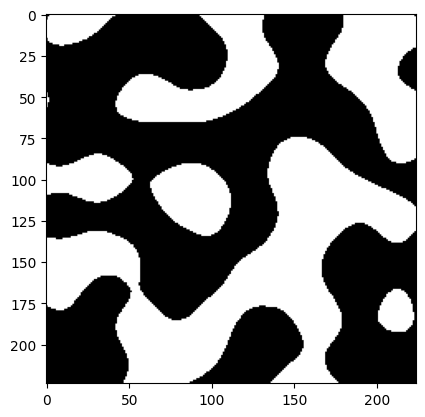

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def perlin_noise(size, scale=40, threshold=0.5):
    """
    Generates binary Perlin noise using PyTorch.

    Args:
        size (tuple): The size of the output tensor (height, width).
        scale (int): The frequency scale of the noise (higher = more detail).
        threshold (float): Threshold for binarization (0 to 1).

    Returns:
        torch.Tensor: A binary Perlin noise tensor of shape `size`.
    """
    def generate_perlin(size, scale):
        grid_size = (size[0] // scale + 1, size[1] // scale + 1)
        gradients = np.random.randn(*grid_size, 2)
        gradients /= np.linalg.norm(gradients, axis=-1, keepdims=True)  # Normalize

        def perlin_interp(t):
            return 6 * t**5 - 15 * t**4 + 10 * t**3  # Smooth interpolation

        lin_x = np.linspace(0, grid_size[1] - 1, size[1])
        lin_y = np.linspace(0, grid_size[0] - 1, size[0])
        x_idx, y_idx = np.meshgrid(lin_x, lin_y)

        x0, y0 = np.floor(x_idx).astype(int), np.floor(y_idx).astype(int)
        x1, y1 = np.clip(x0 + 1, 0, grid_size[1] - 1), np.clip(y0 + 1, 0, grid_size[0] - 1)

        sx, sy = perlin_interp(x_idx - x0), perlin_interp(y_idx - y0)

        def dot_grid_gradient(ix, iy, x, y):
            dx, dy = x - ix, y - iy
            return (dx * gradients[iy, ix, 0] + dy * gradients[iy, ix, 1])

        n00 = dot_grid_gradient(x0, y0, x_idx, y_idx)
        n10 = dot_grid_gradient(x1, y0, x_idx, y_idx)
        n01 = dot_grid_gradient(x0, y1, x_idx, y_idx)
        n11 = dot_grid_gradient(x1, y1, x_idx, y_idx)

        nx0 = (1 - sx) * n00 + sx * n10
        nx1 = (1 - sx) * n01 + sx * n11
        value = (1 - sy) * nx0 + sy * nx1

        value = (value - value.min()) / (value.max() - value.min())  # Normalize to 0-1
        return value

    perlin = generate_perlin(size, scale)
    binary_noise = (perlin > threshold).astype(np.float32)  # Convert to binary

    return torch.tensor(binary_noise)

# Example usage
size = (224, 224)
binary_noise = perlin_noise(size, scale=40)
print(binary_noise.shape)

plt.imshow(binary_noise, cmap='gray')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


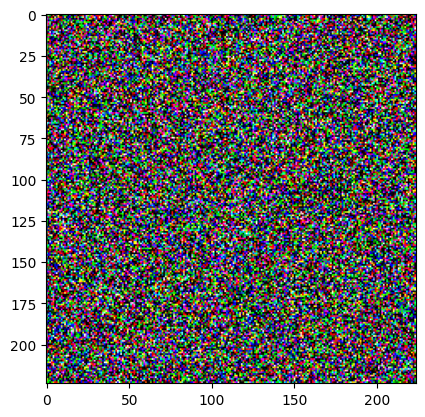

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


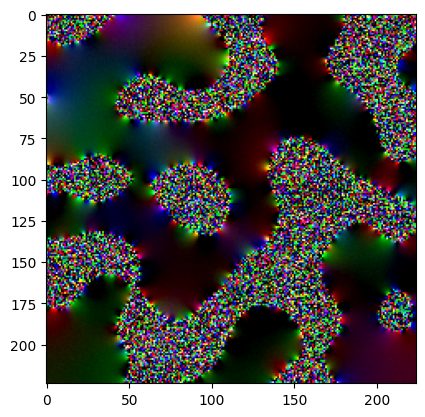

In [8]:
from data.util import blur_image

image = torch.randn((3,224,224))
blurred = blur_image(image,binary_noise)


plt.imshow(image.detach().cpu().numpy().transpose(1,2,0))
plt.show()
plt.imshow(blurred.detach().cpu().numpy().transpose(1,2,0))
plt.show()

